# Evaluate VarDyn

![header](../figures/logos_partenaires_DC_InternalWaves2.jpg)

## Run evaluation metrics
 

## Californian OSSE Xover, VarDyn



***
**Authors:** Datlas <br>
**Copyright:** 2024 Datlas <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h1><center>Californian OSSE Xover: VarDyn seperation maps</center></h1>
 <h5><center> The notebook aims to evaluate VarDyn seperation Internal Waves and Balance Motion maps.</center></h5> 
</div>

## Libraries

In [1]:
import xarray as xr
import numpy as np
import hvplot.xarray
import pyinterp
import dask
import warnings
import xrft
import os
import sys
import pandas as pd
import logging
warnings.filterwarnings('ignore')

In [2]:
sys.path.append('..')

In [3]:
from src.mod_oi import *
from src.mod_inout import *
from src.mod_regrid import *
from src.mod_eval import *
from src.mod_plot import *

## Parameters

In [4]:
# Domain for analysis
time_min = numpy.datetime64('2012-06-10')                # domain min time
time_max = numpy.datetime64('2012-06-30')                # domain max time
lon_min = 190.5                                        # domain min lon
lon_max = 199.5                                        # domain max lon
lat_min = 20.5                                         # domain min lat
lat_max = 29.5                                        # domain max lat

## Open reference and reconstruction files

In [5]:

dc_ref = xr.open_mfdataset('../dc_data/dc_ref_eval_coarse/*.nc')
dc_ref = dc_ref.rename({'longitude':'lon', 'latitude':'lat'})
dc_ref = dc_ref.sel({'time':slice(time_min,time_max)})
dc_ref = dc_ref.isel({'time':slice(1,len(dc_ref.time))})
dc_ref = dc_ref.where(dc_ref.lon>lon_min,drop=True)
dc_ref = dc_ref.where(dc_ref.lon<lon_max,drop=True)
dc_ref = dc_ref.where(dc_ref.lat>lat_min,drop=True)
dc_ref = dc_ref.where(dc_ref.lat<lat_max,drop=True)
dc_ref

<xarray.Dataset>
Dimensions:  (time: 480, lat: 215, lon: 215)
Coordinates:
  * lat      (lat) float32 20.54 20.58 20.62 20.67 ... 29.33 29.38 29.42 29.46
  * lon      (lon) float32 190.5 190.6 190.6 190.7 ... 199.3 199.4 199.4 199.5
  * time     (time) datetime64[ns] 2012-06-10T01:00:00 ... 2012-06-30
Data variables:
    ssh_bm   (time, lat, lon) float64 dask.array<chunksize=(23, 215, 215), meta=np.ndarray>
    ssh      (time, lat, lon) float64 dask.array<chunksize=(23, 215, 215), meta=np.ndarray>
    ssh_it   (time, lat, lon) float64 dask.array<chunksize=(23, 215, 215), meta=np.ndarray>
Attributes:
    NCO:      netCDF Operators version 4.9.8 (Homepage = http://nco.sf.net, C...
    history:  Wed May 24 17:30:25 2023: ncap2 -A -s ssh_igw=ssh_hf-ssh_bar_60...

In [6]:
ds_reconstruction = xr.open_mfdataset('../dc_data/dc_reconstruction1/hawaii_L3_*.nc')
ds_reconstruction = ds_reconstruction.sel({'time':slice(time_min,time_max)})
ds_reconstruction = ds_reconstruction.isel({'time':slice(1,len(ds_reconstruction.time))})
ds_reconstruction = ds_reconstruction.where(ds_reconstruction.lon>lon_min,drop=True)
ds_reconstruction = ds_reconstruction.where(ds_reconstruction.lon<lon_max,drop=True)
ds_reconstruction = ds_reconstruction.where(ds_reconstruction.lat>lat_min,drop=True)
ds_reconstruction = ds_reconstruction.where(ds_reconstruction.lat<lat_max,drop=True)
ds_reconstruction


<xarray.Dataset>
Dimensions:  (time: 480, lat: 143, lon: 143)
Coordinates:
  * time     (time) datetime64[ns] 2012-06-10T01:00:00 ... 2012-06-30
  * lon      (lon) float64 190.6 190.6 190.7 190.8 ... 199.2 199.3 199.4 199.4
  * lat      (lat) float64 20.56 20.62 20.69 20.75 ... 29.25 29.31 29.38 29.44
Data variables:
    u_it     (time, lat, lon) float64 dask.array<chunksize=(1, 143, 143), meta=np.ndarray>
    v_it     (time, lat, lon) float64 dask.array<chunksize=(1, 143, 143), meta=np.ndarray>
    ssh_it   (time, lat, lon) float64 dask.array<chunksize=(1, 143, 143), meta=np.ndarray>
    ssh_bm   (time, lat, lon) float64 dask.array<chunksize=(1, 143, 143), meta=np.ndarray>
    SSH_tot  (time, lat, lon) float64 dask.array<chunksize=(1, 143, 143), meta=np.ndarray>

## Interpolated reconstruction on reference grid

In [7]:
%%time

var_source = ['SSH_tot','ssh_bm','ssh_it']
var_target = ['ssh','ssh_bm','ssh_it']

# Regrid    
ds_reconstruction_regrid = oi_regrid(ds_reconstruction, dc_ref, var_source, var_target)
ds_reconstruction_regrid

CPU times: user 1min 4s, sys: 4.67 s, total: 1min 9s
Wall time: 41.5 s


<xarray.Dataset>
Dimensions:  (time: 480, lat: 215, lon: 215)
Coordinates:
  * time     (time) datetime64[ns] 2012-06-10T01:00:00 ... 2012-06-30
  * lon      (lon) float32 190.5 190.6 190.6 190.7 ... 199.3 199.4 199.4 199.5
  * lat      (lat) float32 20.54 20.58 20.62 20.67 ... 29.33 29.38 29.42 29.46
Data variables:
    ssh      (time, lat, lon) float64 0.9064 0.9061 0.9059 ... 0.8392 0.8396
    ssh_bm   (time, lat, lon) float64 0.9218 0.9215 0.9214 ... 0.84 0.8403 0.841
    ssh_it   (time, lat, lon) float64 -0.01534 -0.01547 ... -0.001162 -0.001402

## Plot reference and reconstruction

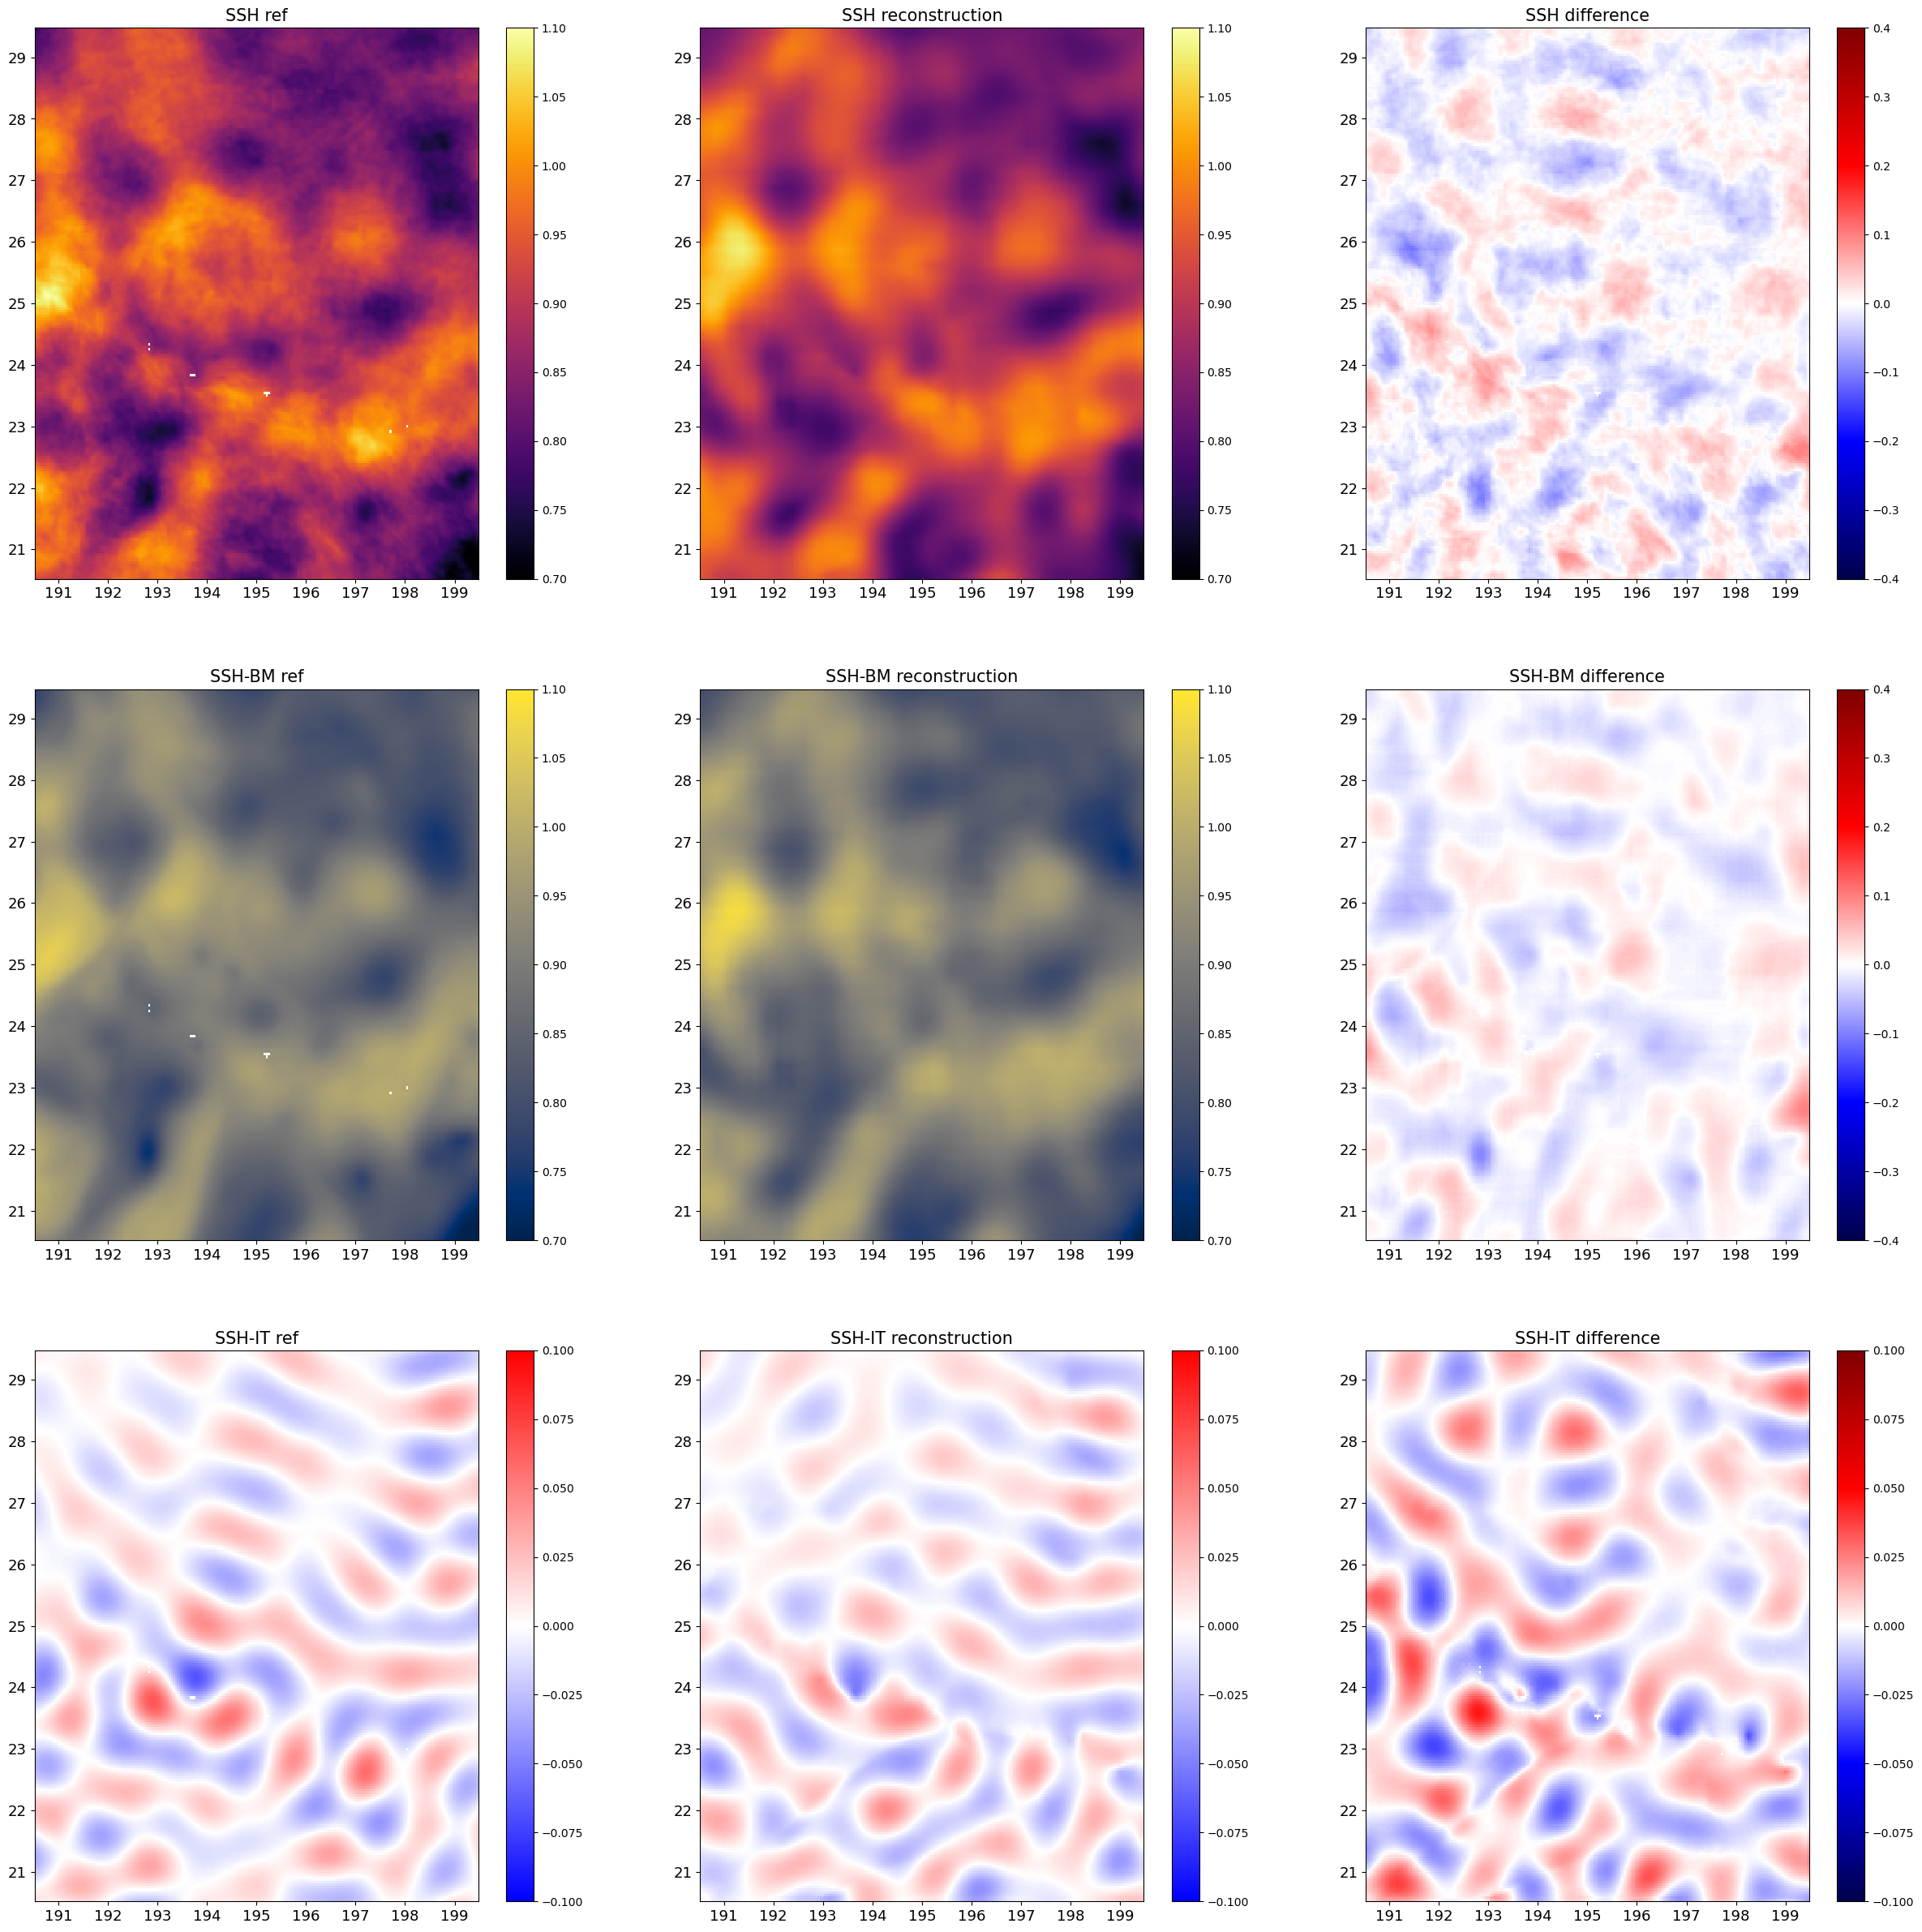

In [8]:
it = 479

path_save_fig = '../results/DC_InternalWaves_OSSE_plot_time'+str(it)+'_201206_VarDyn.png'

plot_maps_and_differences(dc_ref,ds_reconstruction_regrid,it,path_save_fig)

## Compute RMSE and compute spatial and temporal effective resolution

In [40]:
%%time

# Eval
rmse_t_oi1, rmse_xy_oi1, leaderboard_nrmse, leaderboard_nrmse_std = rmse_based_scores(ds_reconstruction_regrid, dc_ref, var_target)
psd_oi1, leaderboard_psds_score, leaderboard_psdt_score  = psd_based_scores(ds_reconstruction_regrid, dc_ref,var_target)


CPU times: user 1min 7s, sys: 30.7 s, total: 1min 38s
Wall time: 1min 4s


In [41]:
for var in var_target:
     
    
    data = [[var, 
             leaderboard_nrmse[var], 
             leaderboard_nrmse_std[var], 
             leaderboard_psds_score[var], 
             leaderboard_psdt_score[var],
            'VarDyn',
            'eval_vardyn.ipynb']]
    Leaderboard = pd.DataFrame(data, 
                               columns=['Method', 
                                        "µ(RMSE) ", 
                                        "σ(RMSE)", 
                                        'λx (degree)', 
                                        'λt (days)', 
                                        'Notes',
                                        'Reference'])
    print("Summary of the leaderboard metrics:")
    Leaderboard
    print(Leaderboard.to_markdown())

Summary of the leaderboard metrics:
|    | Method   |   µ(RMSE)  |   σ(RMSE) |   λx (degree) |   λt (days) | Notes   | Reference         |
|---:|:---------|-----------:|----------:|--------------:|------------:|:--------|:------------------|
|  0 | ssh      |       0.98 |         0 |          1.53 |       14.14 | VarDyn  | eval_vardyn.ipynb |
Summary of the leaderboard metrics:
|    | Method   |   µ(RMSE)  |   σ(RMSE) |   λx (degree) |   λt (days) | Notes   | Reference         |
|---:|:---------|-----------:|----------:|--------------:|------------:|:--------|:------------------|
|  0 | ssh_bm   |       0.98 |         0 |          1.52 |       14.28 | VarDyn  | eval_vardyn.ipynb |
Summary of the leaderboard metrics:
|    | Method   |   µ(RMSE)  |   σ(RMSE) |   λx (degree) |   λt (days) | Notes   | Reference         |
|---:|:---------|-----------:|----------:|--------------:|------------:|:--------|:------------------|
|  0 | ssh_it   |       0.38 |      0.07 |          3.79 |        1.

<br>

## Temporal spectrum 

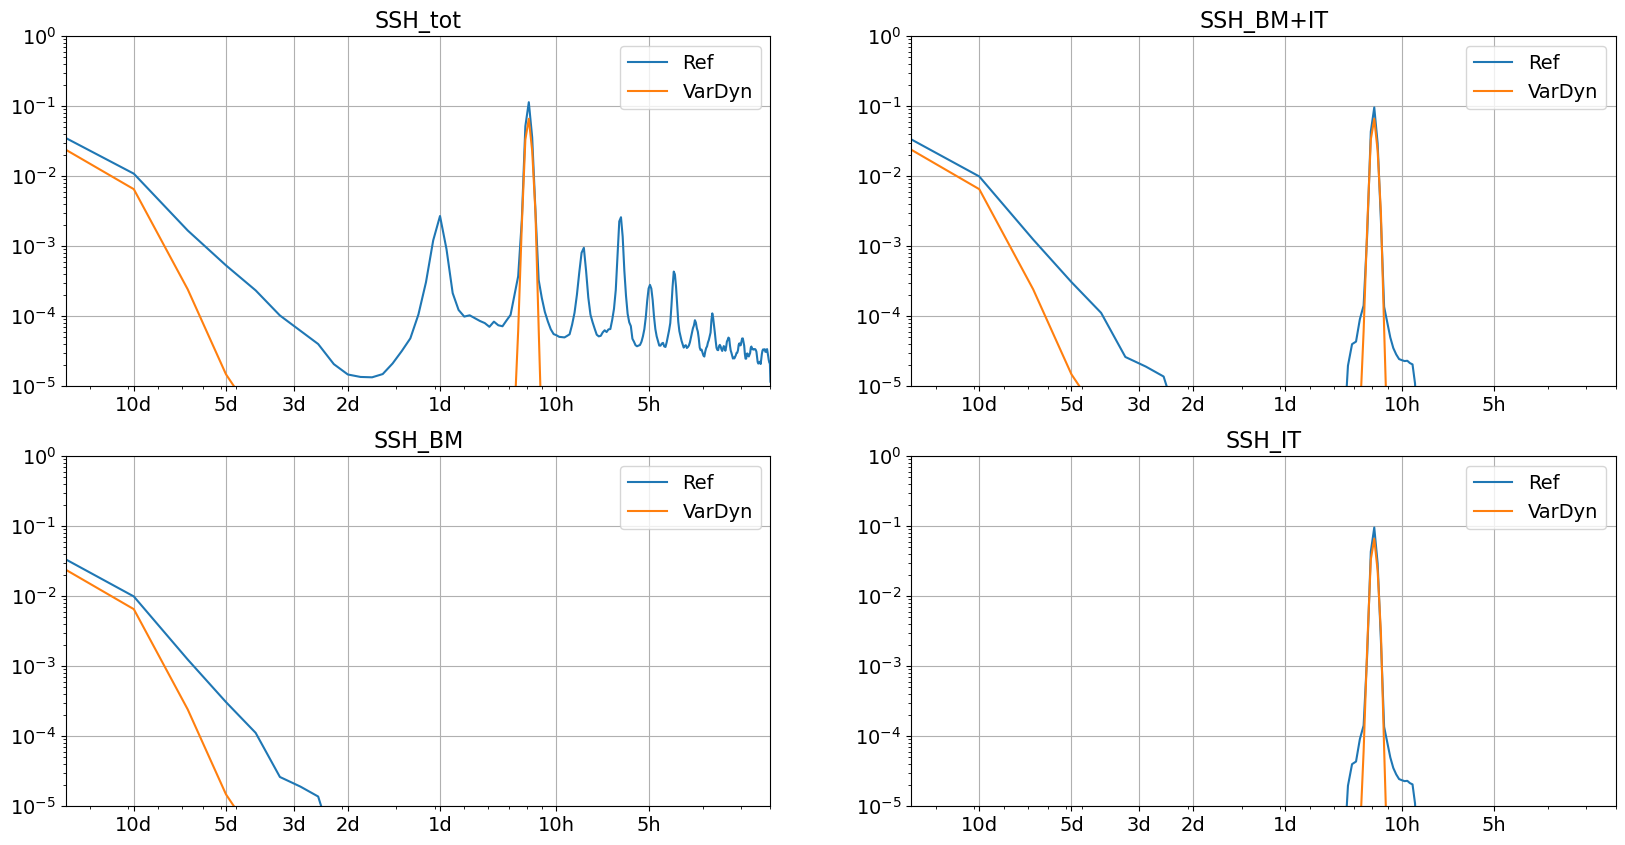

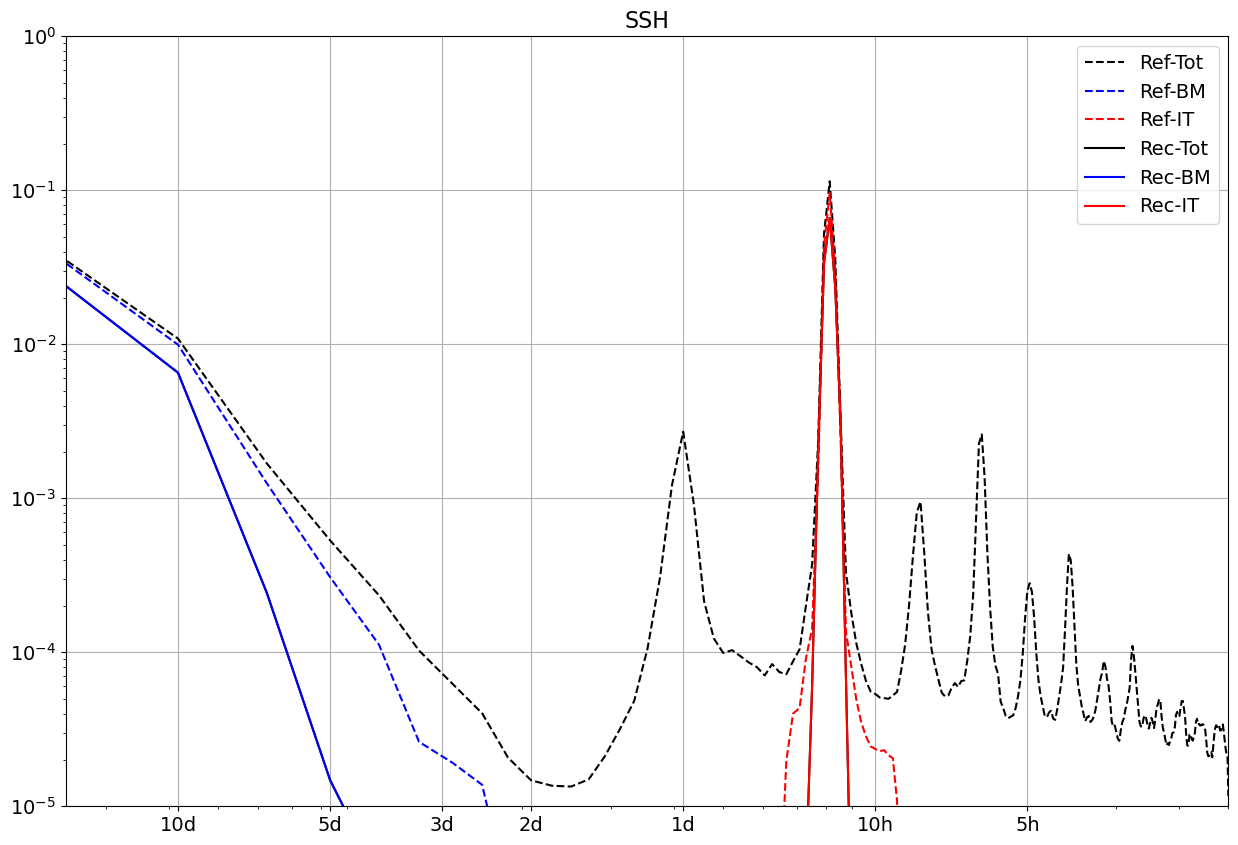

CPU times: user 20.4 s, sys: 9.71 s, total: 30.1 s
Wall time: 23 s


In [42]:
%%time

path_save_fig = '../results/DC_InternalWaves_OSSE_temporalspectrum_201206_VarDyn.png'

plot_temporal_spectrum(dc_ref,ds_reconstruction_regrid,path_save_fig)

## Omega-k spectrum

CPU times: user 2min 24s, sys: 38.5 s, total: 3min 2s
Wall time: 2min 41s


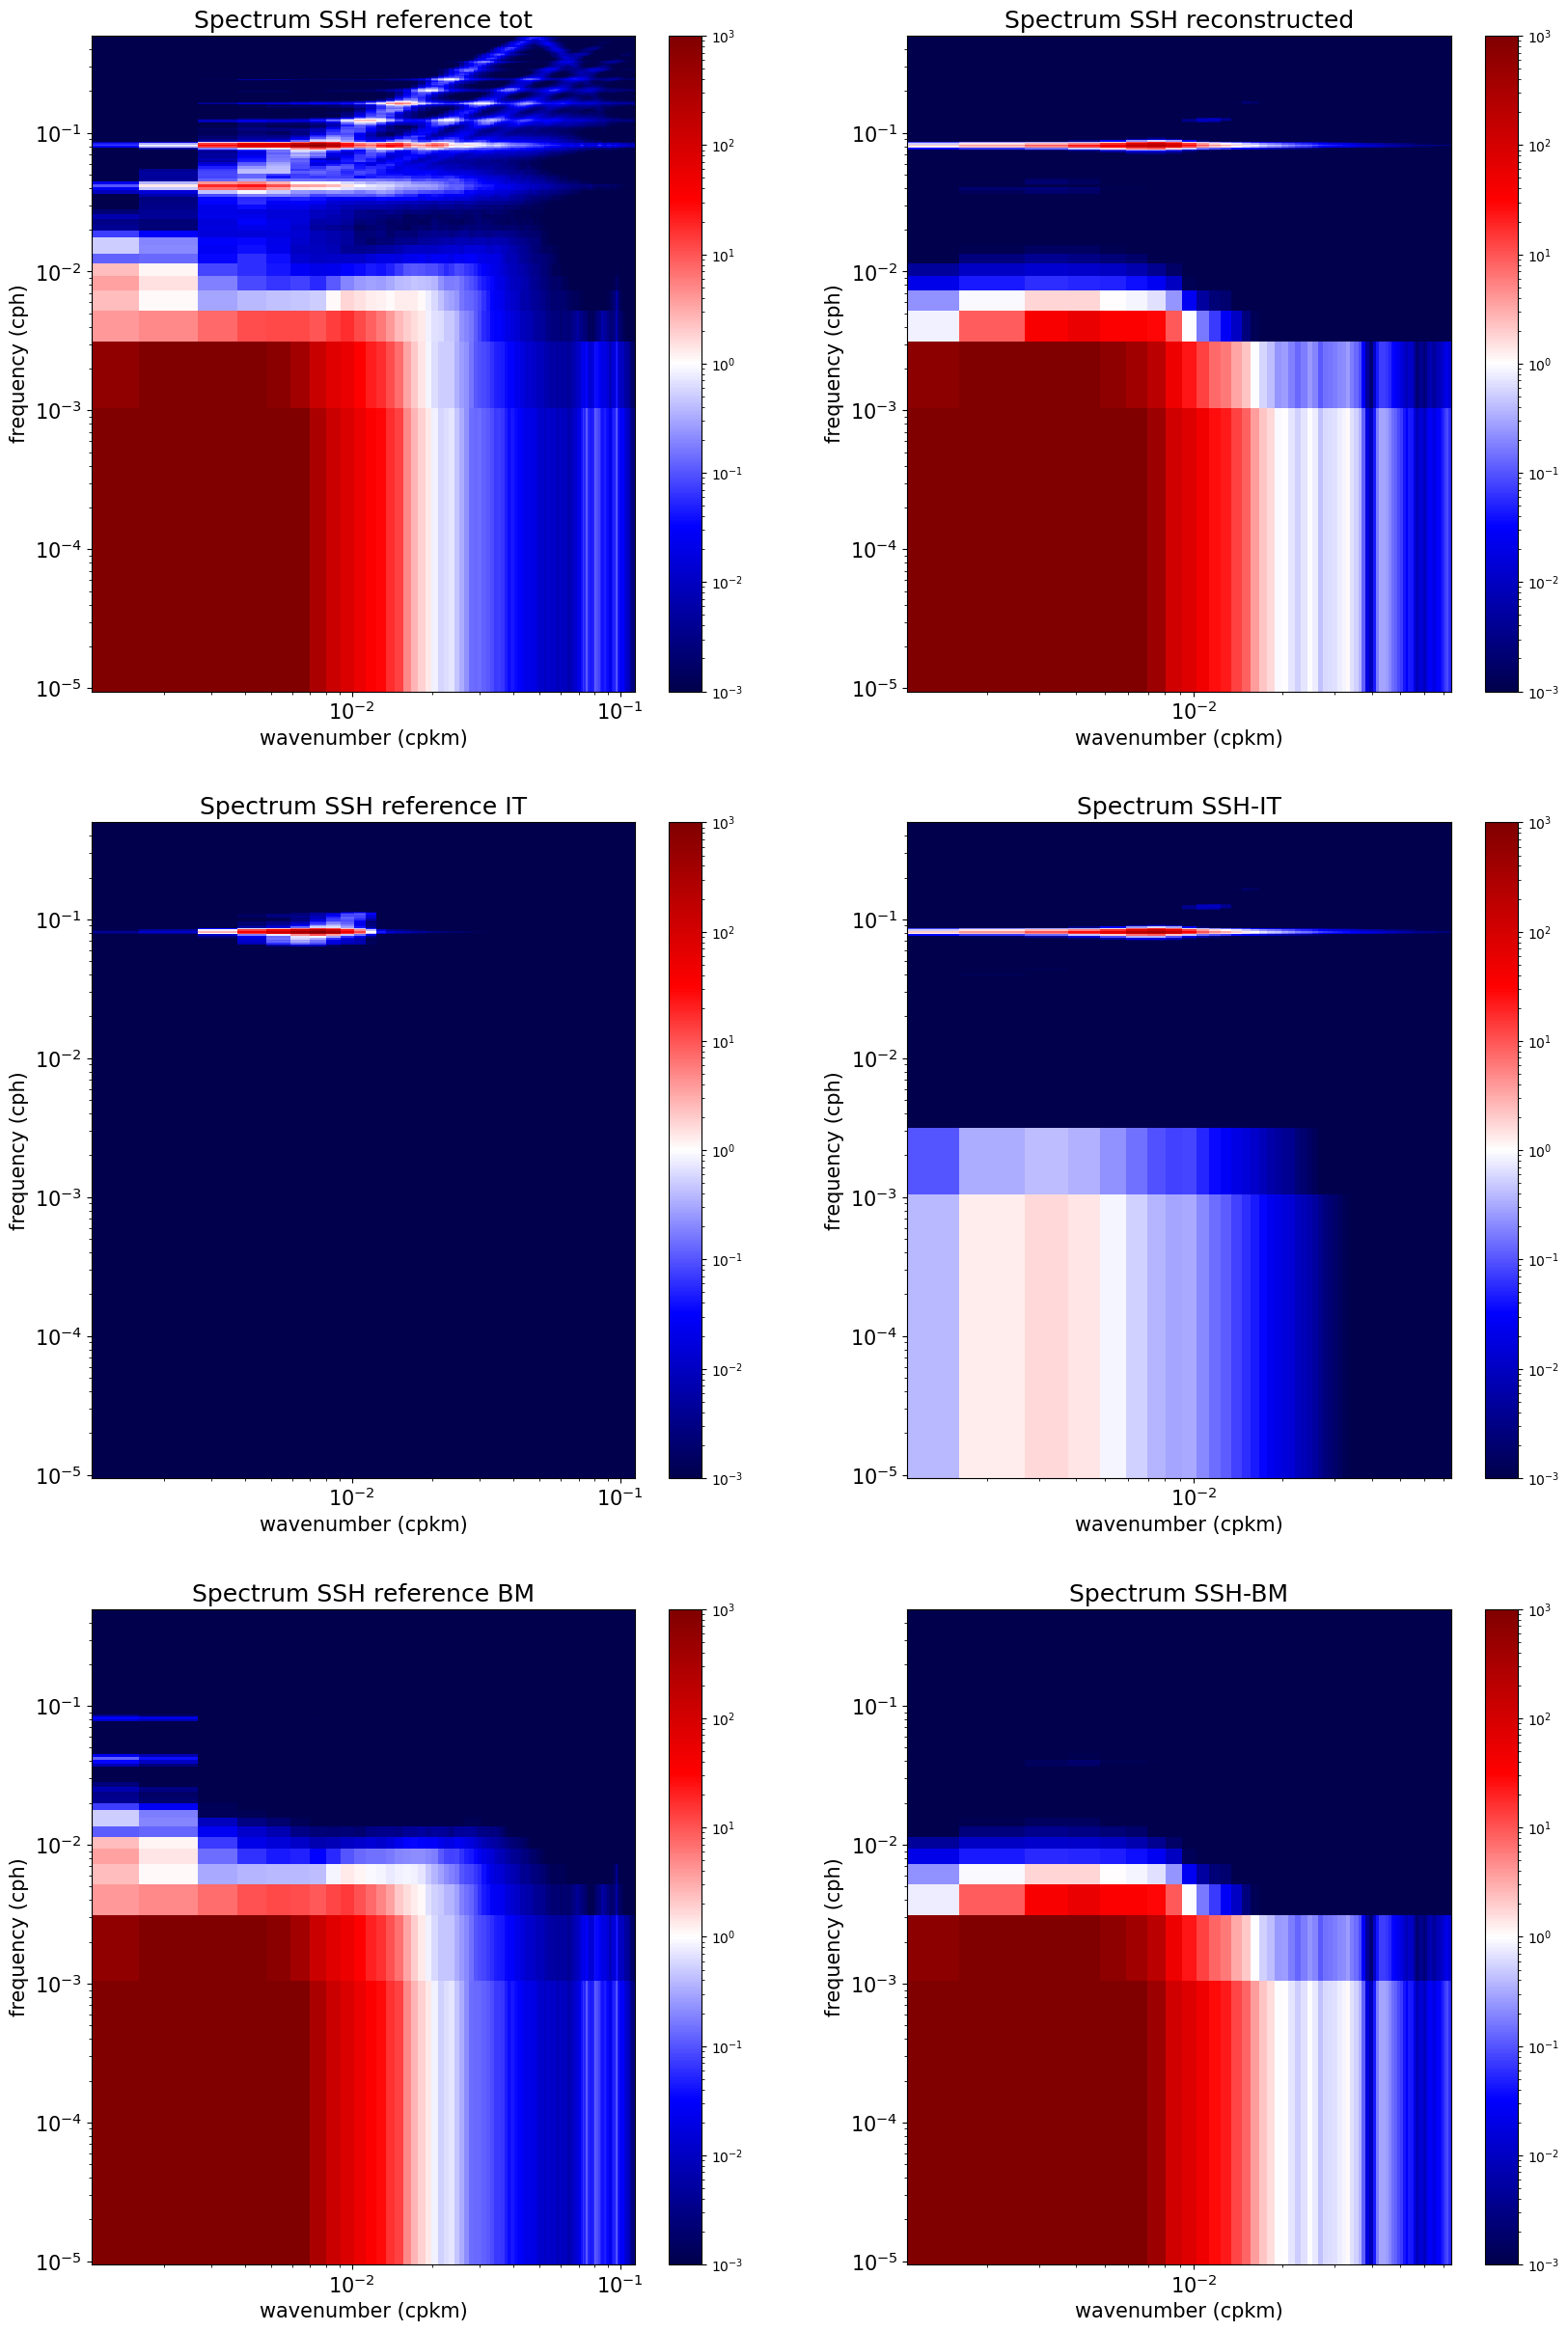

In [43]:
%%time

path_save_fig = '../results/DC_InternalTides_OSSE_OmegaKspectrum_201206_VarDyn.png'

plot_omegak_spectrum(dc_ref,ds_reconstruction,path_save_fig)


## Omega-k noise-to-signal ratio

CPU times: user 3min 43s, sys: 1min 11s, total: 4min 54s
Wall time: 4min 9s


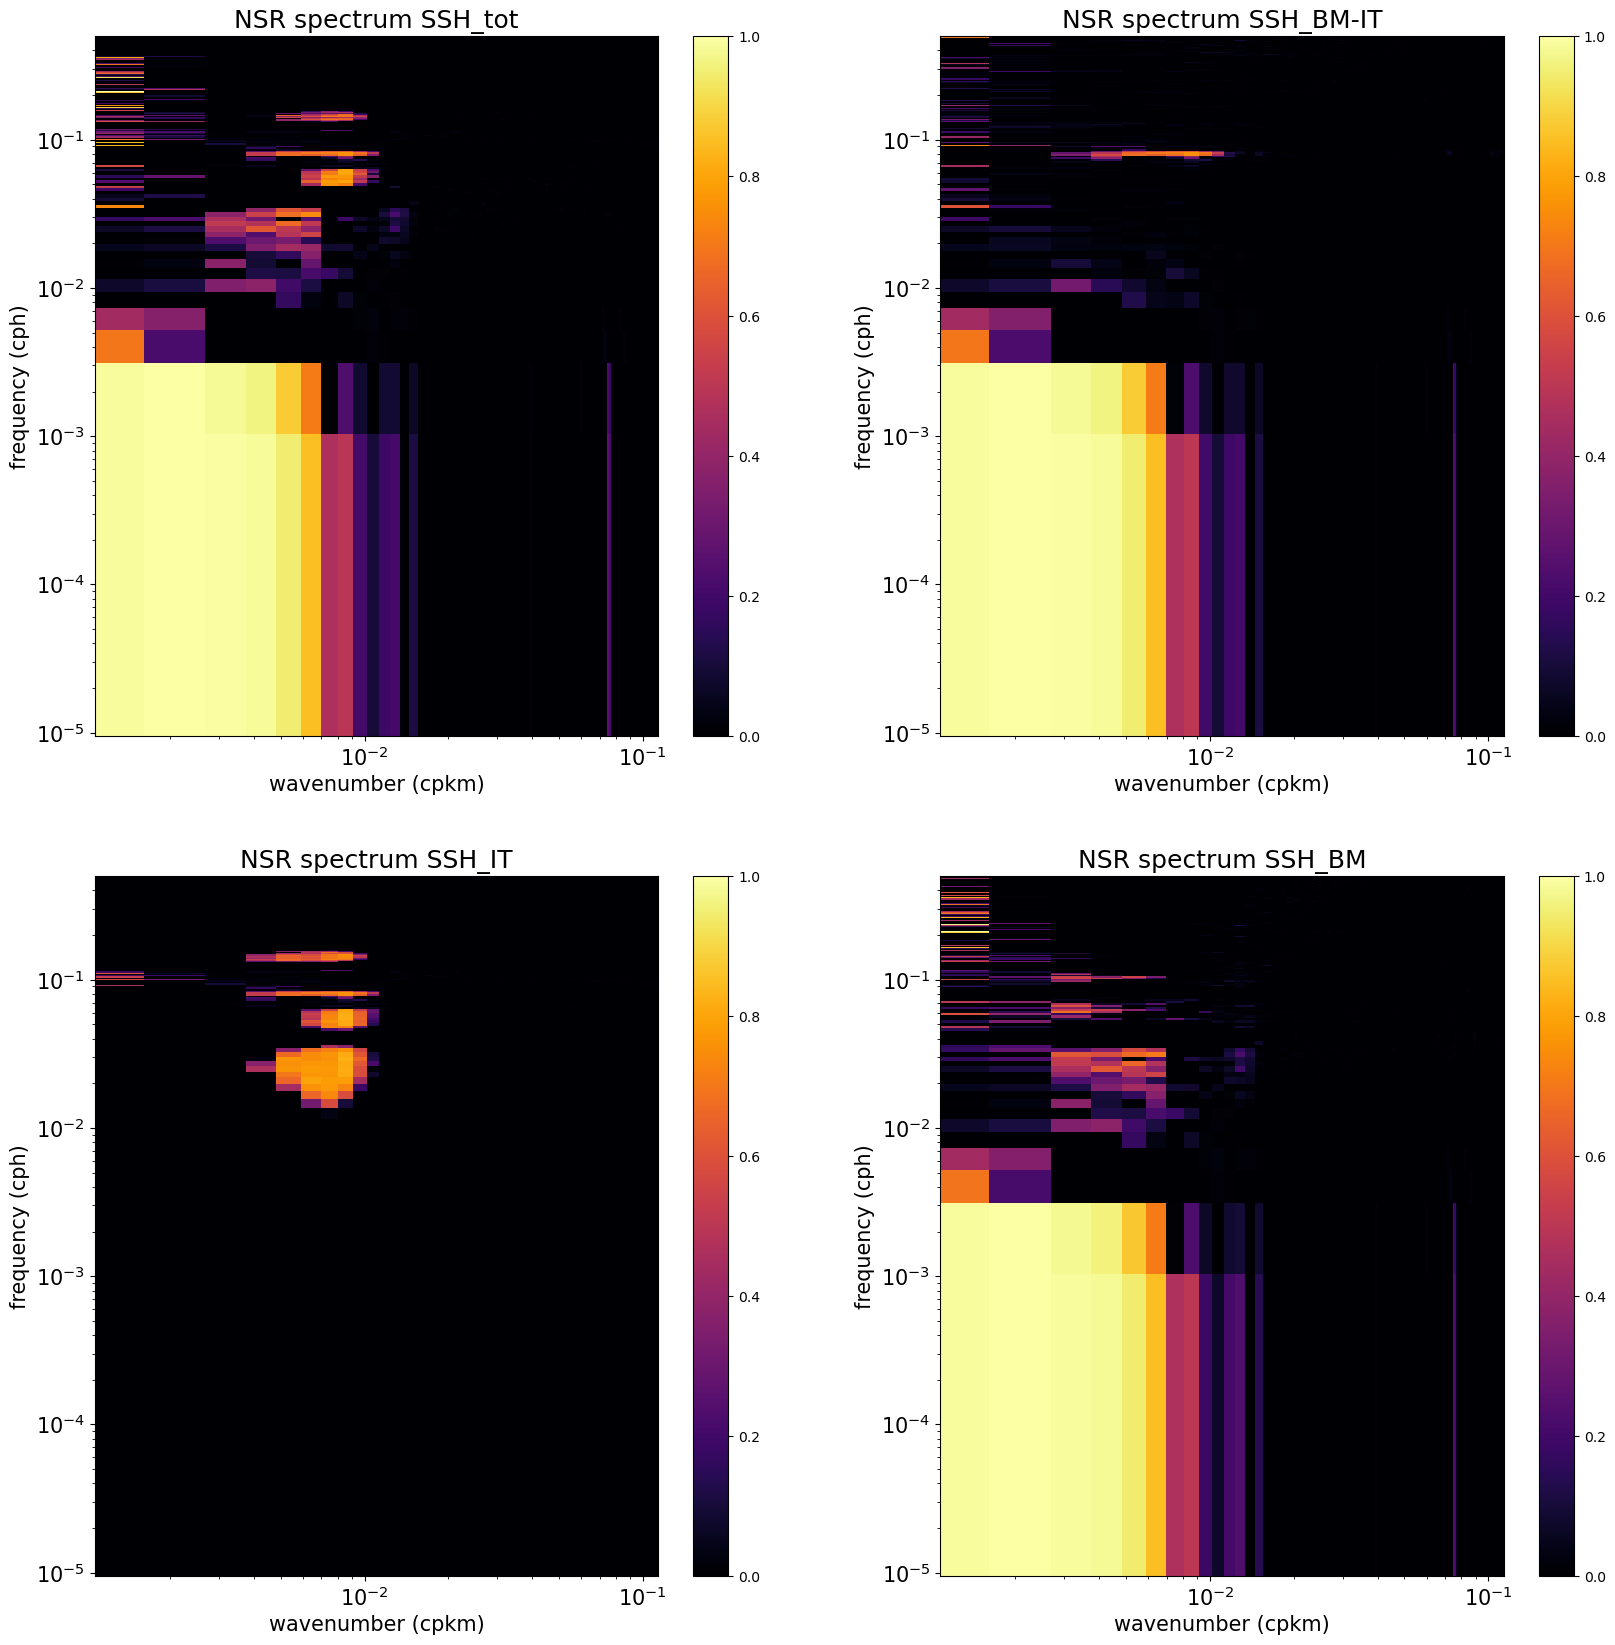

In [44]:
%%time

path_save_fig = '../results/DC_InternalTides_OSSE_NSRspectrum_201206_VarDyn.png'

plot_nsr_spectrum(dc_ref,ds_reconstruction_regrid, path_save_fig)
